## Pytorch MRI image class

The purpose of this notebook is to work out a class that I an consistently use for the super-resolution and just general image training of MRI and potentially other medical imaging data types.

It's become clear that everyone seems to have a different, unique, way of loading and organizing their data into a format that can be fed into a Pytorch `Dataset` for training a model. This can include creating intermediate `.png` images in order to limit memory usage/training time on personal hardware.

Goals for this tool:
1. Given an input folder, list all files that match a particular `prefix` and `suffix`
2. Display sample images from the list for assurance
3. Create randomly shuffled/altered images at different resolutions (gaussian blur, affine transformation, etc.)
    - Make the aspect of saving these images optional
4. Save any image generated in a specified format
5. Be given an input and output folder and generate list of matching data
6. Have locations of matching low and high resolution images (potentially a list for every x2 magnification)


Output file labeling protocol:
To keep things consistent I should probably create a labeling structure that is robust to future changes that I might want to make. This will most likely have to be stored in the string name, unless I want to make an intermediate file that is used as a key for the location of the files relative to the directory.

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil
import numpy as np
from PIL import Image
import random
import cv2
from matplotlib import pyplot
from skimage.transform import rotate, AffineTransform, warp, rescale

## Class definition

In [13]:
# The super resolution class:

class sr_gen():
    def __init__(self, inp_dir, HR_out_dir, LR_out_dir, prefix='', suffix=''):
        self.inp_dir = inp_dir
        self.HR_out_dir = HR_out_dir
        self.HR_files = None
        self.LR_out_dir = LR_out_dir
        self.LR_files = None
        self.inp_files = self._get_inp_(prefix, suffix)
        self.template = self.get_template()

    def _get_inp_(self, prefix='', suffix=''):
        # Get the original files that will be used to generate everything
        # Based on the prefix, for now this could be nifti files or png's.
        # Will have to write a "try" statement in order to check for file type
        files = []
        for fil in os.listdir(self.inp_dir):
            if fil.startswith(prefix) & fil.endswith(suffix):
                files.append(fil)
        
        if not files:
            raise FileNotFoundError('No applicable files found in input directory')

        return files

    def _get_LR_out_(self):
        # get list of files in output directory and determine matching files
        return os.listdir(self.LR_out_dir)

    def _get_HR_out_(self):
        return os.listdir(self.HR_out_dir)


    def _view_sample_(self):
        # Function which loads and displays random example image for sanity check
        pyplot.figure()
        f, axes = pyplot.subplots(2,2)
        
        indx = random.randint(0,len(self.inp_files)-1)
        indy = random.randint(0,len(self.HR_files)-1)

        axes[0,0].imshow(np.array(Image.open(self.inp_dir+self.inp_files[indx])))
        axes[1,0].imshow(np.array(Image.open(self.HR_files[indy])))
        axes[1,1].imshow(np.array(Image.open(self.LR_files[indy])))


    def get_template(self):
        # Returns dictonary of all option settings for this class
        try:
            return self.template
        except:
            return {'out_type':'png', # png, nii (?), DICOM (?)
                    'unit':'intensity', #Whether you want RBG or Intensity/DICOM units
                    'resolution':2,
                    'translation_x':10,
                    'translation_y':10,
                    'rotation':0,
                    'scale':2,
                    'patch':False,
                    'step': 10,
                    'keep_blank':False,
                    }

    def save_template(self, temp):
        # apply the provided template for randomization to self for access by other functions
        self.template = temp


    def run(self, clear=False):
        # Run the analysis specified in the template dictionary. If clear is true then the 
        # files in the output directories will be deleted before creating the new images.

        if clear:
            print('Clearing existing output directories')
            shutil.rmtree(self.HR_out_dir, ignore_errors=True)
            shutil.rmtree(self.LR_out_dir, ignore_errors=True)

        # Make the directories where the new files will be saved
        os.makedirs(self.HR_out_dir, exist_ok=True)
        os.makedirs(self.LR_out_dir, exist_ok=True)

        HR_out_files = []
        LR_out_files = []
        
        s = 1/self.template['resolution']
        for im in self.inp_files:
            im_h = np.array(Image.open(self.inp_dir + im))

            # check the dimensions of the image
            #print(f'Shape of High Resolution Image:{im_h.shape}')

            im_h = self.rgb2ycrbcr(im_h)
            im_h = im_h[:,:,0] #Just deal with intensity values at the moment because 
                                # having multiple channels throws off cv2 when saving, 
                                # since it also does BGR instead of RGB and will save a blue image

            # TODO: compare cv2.resize with skimage.rescale or pytorch rescale for this
            im_l = cv2.resize(im_h, (0,0), fx = s, fy =s, interpolation=cv2.INTER_CUBIC)
            im_l = cv2.resize(im_l, (0,0), fx = self.template['resolution'],
            fy=self.template['resolution'], interpolation=cv2.INTER_CUBIC)
            # TODO: The above resizing results in values outside of the range [0, 255] due to 
            # the INTER_CUBIC method. For now I'm just clipping the values, but a more nuanced
            # answer should be found
            im_l = np.clip(im_l, 0, 255)

            if self.template['patch']:
                im, im_h, im_l = self.img_transform(im, im_h, im_l)
                _ = self.img2patches(im, im_h, im_l, keep_blank = self.template['keep_blank'],save=True)
                HR_out_files = HR_out_files + _

            else:
                _ = self.img_transform(im, im_h, im_l, save=True)
                HR_out_files.append(_)
        
        #Do LR first because otherwise HR_out_files is changed
        LR_out_files = [self.LR_out_dir + s for s in HR_out_files]
        HR_out_files = [self.HR_out_dir + s for s in HR_out_files]

        self.HR_files = HR_out_files
        self.LR_files = LR_out_files


    def img_transform(self,im, im_h, im_l, save=False):
        # Transform the original files using a variety of methods

        opp = '' #string for storing the operations performed on the images

        # If shifting in the x or y direction was selected
        if self.template['translation_x'] > 0 | self.template['translation_y'] > 0:
            _a = np.random.randint(0,self.template['translation_x'])
            _b = np.random.randint(0,self.template['translation_y'])
            transform = AffineTransform(translation=(_a, _b))
            im_h = warp(im_h, transform,mode='reflect')
            im_l = warp(im_l, transform,mode='reflect')
            opp += f'_x{_a}_y{_b}'

        if self.template['scale'] > 1:
            _a = np.random.randint(1,self.template['scale']+1)
            transform = AffineTransform(scale=_a)
            im_h = warp(im_h, transform, mode='reflect')
            im_l = warp(im_l, transform,mode='reflect')
            opp+= f'_scale{_a}'

        # If rotation was selected
        if self.template['rotation'] > 0:
            _a = np.random.randint(0,self.template['rotation'])
            im_h = rotate(im_h, _a, mode="reflect")
            im_l = rotate(im_l, _a, mode="reflect")
            opp+= f'_rot{_a}'

        opp = im.split('.')[0] + opp

        if save:
            print(f'Saving image: {opp}')
            cv2.imwrite(f'{self.HR_out_dir}/{opp}.png', im_h)
            cv2.imwrite(f'{self.LR_out_dir}/{opp}.png', im_l)
            return opp
        else:
            return opp, im_h, im_l

    def img2patches(self, im, im_h, im_l=False, keep_blank=False, save=False):
        # Take a given image and generate patches and returns a stack of images
        # im : str, name of the image being cut into patches
        # im_h : ndarray, numpy array of the high-resolution image
        # im_l : ndarray, numpy array of the low-resolution image. If this is false, 
        # then you only want to make patches from one image (in this case im_h)

        patch_size = self.template['patch']
        step = self.template['step']


        # Get the height and width of the provided images
        h_h, w_h = im_h.shape
        h_l, w_l = im_l.shape

        # Create a numpy stack following Pytorch protocols
        HR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step)),patch_size,patch_size))
        if isinstance(im_l, np.ndarray):
            LR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step)),patch_size,patch_size))

        im_name = im.split('.')[0]

        cnt = 0
        blank = 0

        for i in range(0,w_h,step):
            for j in range(0,h_h,step):
                if i+patch_size < w_h and j+patch_size < h_h:

                    sample_h = im_h[j:j+patch_size, i: i+patch_size]
                    if isinstance(im_l, np.ndarray):
                        sample_l = im_l[j:j+patch_size, i:i+patch_size]

                    # if you've chosen to keep blank patches or if the patch is not blank add 
                    # it to the stack
                    if keep_blank or (sample_h.max() > 0 or sample_l.max() > 0):
                        HR_stack[cnt, :,:] = sample_h
                        if isinstance(im_l, np.ndarray):
                            LR_stack[cnt,:,:] = sample_l
                        cnt += 1
                    else:
                        blank += 1



        # Return a list of image names and numpy array with the first cnt layers
        HR_fnames = []
        for i in range(cnt):
            HR_fnames.append(f'{im_name}_{i}.png')

        if save: #Whether to save a patch if it is blank/intensity value of 0
            for i in range(cnt):
                cv2.imwrite(f'{self.HR_out_dir}/{im_name}_{i}.png', HR_stack[i,:,:])
                if isinstance(im_l, np.ndarray):
                    cv2.imwrite(f'{self.LR_out_dir}/{im_name}_{i}.png', LR_stack[i,:,:])
            return HR_fnames
        
        else:
            if isinstance(im_l, np.ndarray):
                return HR_fnames, HR_stack[:cnt,:,:], LR_stack[:cnt,:,:]
            else:
                return HR_fnames, HR_stack[:cnt,:,:]
        


    def rgb2ycrbcr(self, img_rgb):
        # Takes an RBG image and returns it as a YCRBCR image (if you just want to focus
        #  on luminance values of an image)

        img_rgb = img_rgb.astype(np.float32)

        img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCR_CB)
        img_ycbcr = img_ycrcb[:,:,(0,2,1)].astype(np.float32)
        img_ycbcr[:,:,0] = (img_ycbcr[:,:,0]*(235-16)+16)/255.0
        img_ycbcr[:,:,1:] = (img_ycbcr[:,:,1:]*(240-16)+16)/255.0

        return img_ycbcr


    def load_image_pair(self, im_id):
        # A method which loads the provided file and returns a numpy array
        # this is used because it will remember in the template dictionary how
        # the images were saved (either as RBG or intensity values or 3D array). 
        # This will help minimize headaches caused by different image types.

        # im_id can either be the index value or the name of the file
        if isinstance(im_id, int):
            HR_file = self.HR_files[im_id]
            LR_file = self.LR_files[im_id]
        elif isinstance(im_id, str):
             _ = self.HR_files.index(im_id)
             HR_file = self.HR_files[_]
             LR_file = self.LR_files[_]
        else:
            TypeError("Invalid image identifier, please input a string to integer")

        # Check what data type to load from the template
        if self.template['out_type'] == 'png':
            im_h = np.array(Image.open(HR_file))
            im_l = np.array(Image.open(LR_file))


        return im_h, im_l

    def match_altered(self, update=False):
        # Get the files that have been generated in the output directory
        # If update is false, then just return a list of matched names, if true then
        # change the class variable values accordingly.
        hr_files = self._get_HR_out_()
        lr_files = self._get_LR_out_()

        # Get a set of all the files with agreement before the metadata
        if len(hr_files) > len(lr_files):
            matches = list(set(hr_files)-(set(hr_files)-set(lr_files)))
        else:
            matches = list(set(lr_files)-(set(lr_files)-set(hr_files)))

        if update:
            # If you want to save these matched files as class variables
            self.HR_files = [self.HR_out_dir + _ for _ in matches]
            self.LR_files = [self.LR_out_dir + _ for _ in matches]
        else:
            return matches

    def change_out(self, HR_out_dir, LR_out_dir):
        # Change the output locations so you can save into a new file
        self.HR_out_dir = HR_out_dir
        self.HR_files = None
        self.LR_out_dir = LR_out_dir
        self.LR_files = None
        

In [14]:
qq = sr_gen('./data/raw/nii_sub_HR/','./data/raw/HR_output/','./data/raw/LR_output/')

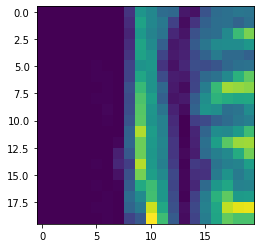

In [22]:
#qq.match_altered(True)
#pyplot.imshow(qq.load_image_pair(4)[1])

In [343]:
temp = qq.get_template()
temp["patch"]=20
temp["step"]=60
qq.save_template(temp)

In [344]:
qq.run(clear=True)

Clearing existing output directories


In [345]:
qq.__get_inp__()

['141.png',
 '155.png',
 '140.png',
 '147.png',
 '145.png',
 '154.png',
 '157.png',
 '151.png',
 '153.png',
 '148.png',
 '149.png',
 '156.png',
 '144.png',
 '142.png',
 '143.png',
 '158.png',
 '159.png',
 '152.png',
 '160.png',
 '150.png',
 '146.png']

<Figure size 432x288 with 0 Axes>

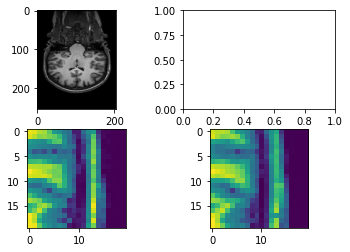

In [349]:
qq.__view_sample__()

In [128]:
grayim = np.zeros(im_h.shape)
grayim[:,:,0]= grayim[:,:,1] = grayim[:,:,2] = im_h[:,:,0]

cv2.imwrite('test.png',grayim[:,:,0])

True

In [138]:
np.array(Image.open('./data/raw/HR_output/140_scale1.png')).shape

(256, 204, 3)

In [340]:
qq.LR_files

['./data/raw/LR_output/141_scale1_0.png',
 './data/raw/LR_output/141_scale1_1.png',
 './data/raw/LR_output/141_scale1_2.png',
 './data/raw/LR_output/141_scale1_3.png',
 './data/raw/LR_output/141_scale1_4.png',
 './data/raw/LR_output/141_scale1_5.png',
 './data/raw/LR_output/141_scale1_6.png',
 './data/raw/LR_output/141_scale1_7.png',
 './data/raw/LR_output/141_scale1_8.png',
 './data/raw/LR_output/141_scale1_9.png',
 './data/raw/LR_output/141_scale1_10.png',
 './data/raw/LR_output/141_scale1_11.png',
 './data/raw/LR_output/141_scale1_12.png',
 './data/raw/LR_output/141_scale1_13.png',
 './data/raw/LR_output/141_scale1_14.png',
 './data/raw/LR_output/141_scale1_15.png',
 './data/raw/LR_output/155_scale1_0.png',
 './data/raw/LR_output/155_scale1_1.png',
 './data/raw/LR_output/155_scale1_2.png',
 './data/raw/LR_output/155_scale1_3.png',
 './data/raw/LR_output/155_scale1_4.png',
 './data/raw/LR_output/155_scale1_5.png',
 './data/raw/LR_output/155_scale1_6.png',
 './data/raw/LR_output/155_s

In [351]:
np.array(Image.open('./test.png')).shape

(256, 204)